# Clustering based on Seurat paper

Use Scanpy implementation of Seurat

- https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/pbmc3k.html
- https://satijalab.org/seurat/v1.4/pbmc3k_tutorial.html

In [1]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
mpl.rc("savefig", dpi=300)

In [3]:
ds_name = 'AS_et_al' # 'AS_et_al', 'AP_et_al', 'SP_et_al'

# Read data

##### cell info

In [4]:
cell_df = pd.read_csv('../preprocessed_data/scRNAseq/{}_cell_metadata.csv'.format(ds_name), index_col=0)
print (cell_df.shape)
cell_df.head()

(1247, 1)


,sample_id
RHH2176,HN120P
RHH2177,HN120P
RHH2178,HN120P
RHH2179,HN120P
RHH2180,HN120P


In [5]:
if ds_name == 'AS_et_al':
    cell_df.loc[:, 'batch'] = [c[0:3] for c in cell_df.index]
    cell_df.loc[:, 'cell_number'] = [int(c[3:]) for c in cell_df.index]

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1

In [6]:
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=72)

import anndata as an

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2


In [7]:
norm_type = 'tpm'
adata = sc.read_csv('../preprocessed_data/scRNAseq/{}_{}.csv'.format(ds_name, norm_type)).T
# adata.var_names_make_unique() # no need for gene_id

In [8]:
adata

AnnData object with n_obs × n_vars = 1171 × 15144

In [9]:
# add cell info
adata.obs = pd.merge(adata.obs, cell_df, how='left', left_index=True, right_index=True)

# Clustering

#### Preprocessing

- cells and genes were already filtered out

In [10]:
# just add this line to get 'n_genes'
sc.pp.filter_cells(adata, min_genes=0)

# sc.pp.filter_cells(adata, min_genes=5000)
# sc.pp.filter_genes(adata, min_cells=50)

adata

AnnData object with n_obs × n_vars = 1171 × 15144
    obs: 'sample_id', 'batch', 'cell_number', 'n_genes'

##### Mito-gene

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [11]:
mito_genes = adata.var_names.str.startswith('MT-')

In [12]:
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'sample_id' as categorical
... storing 'batch' as categorical


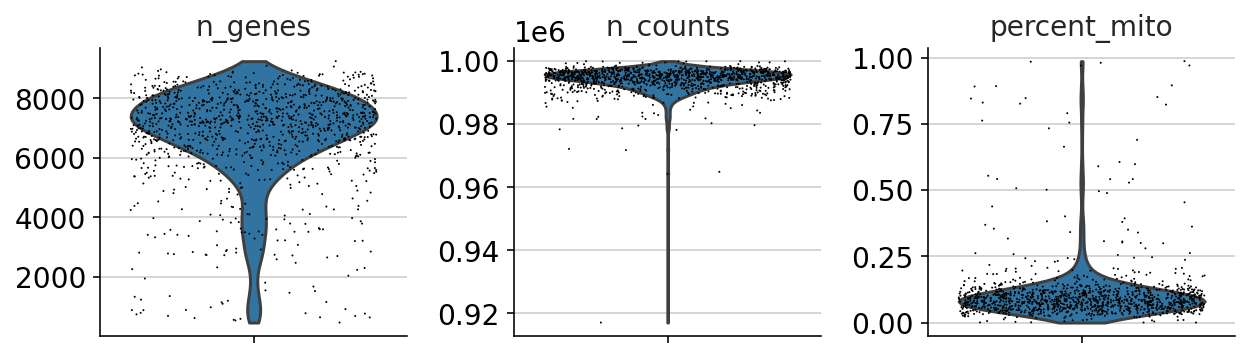

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

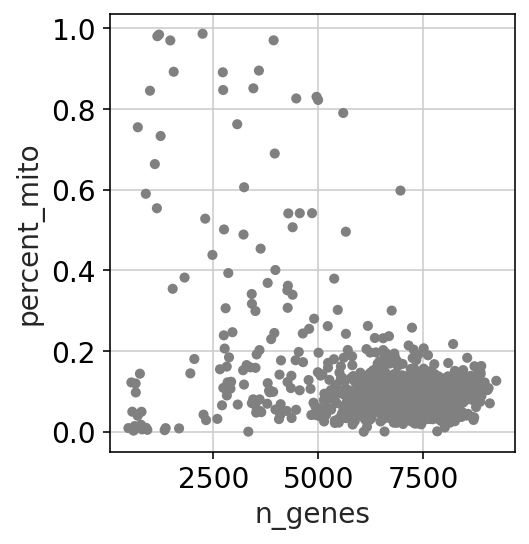

In [14]:
sc.pl.scatter(adata, x='n_genes', y='percent_mito')
# sc.pl.scatter(adata, x='n_counts', y='n_genes')

In the tutorial, cutoff for percent_mito is 0.05. However, as we already filtered out some genes, we use cutoff of 0.25 instead.

In [15]:
adata = adata[adata.obs['percent_mito'] <= 0.25, :] # 0.05 in the tutorial
adata

View of AnnData object with n_obs × n_vars = 1116 × 15144
    obs: 'sample_id', 'batch', 'cell_number', 'n_genes', 'percent_mito', 'n_counts'

##### log normalize

In [16]:
sc.pp.log1p(adata)

In [17]:
adata.raw = adata

##### highly variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


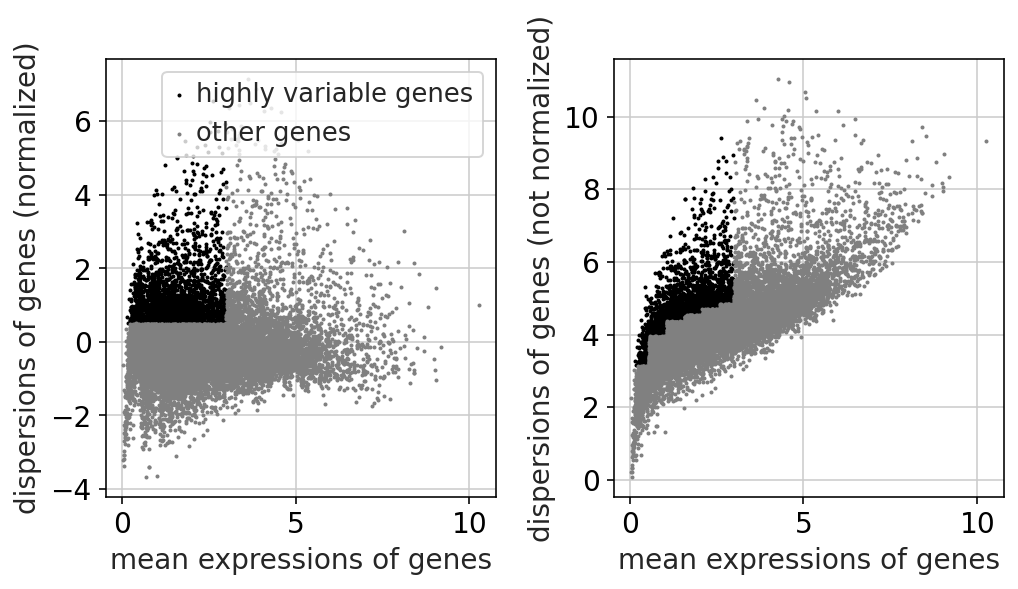

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [19]:
adata = adata[:, adata.var['highly_variable']]

- skip regress out n_counts and percent_mito
- skip std clipping

##### PCA

In [20]:
# adata.obs.loc[:, 'cell_number_RHH'] = adata.obs['cell_number'].values
# adata.obs.loc[adata.obs['cell_number_RHH'] < 1470, 'cell_number_RHH'] = 1200
# adata.obs.loc[adata.obs['cell_number_RHH'] > 2559, 'cell_number_RHH'] = 2600

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


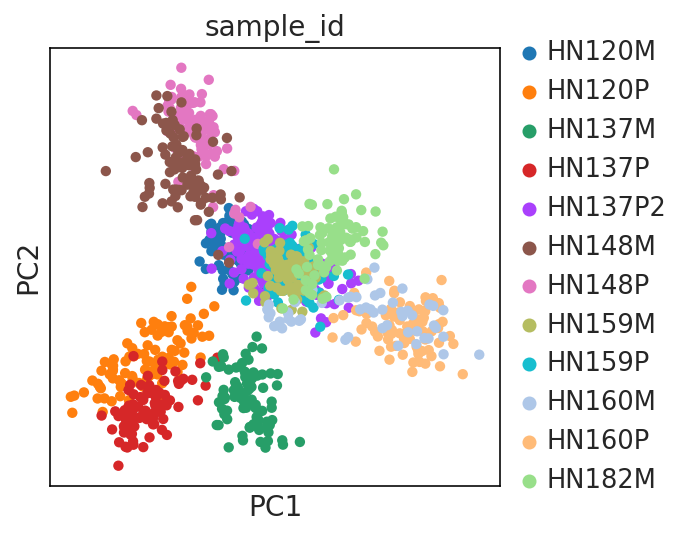

In [21]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color=['sample_id'])

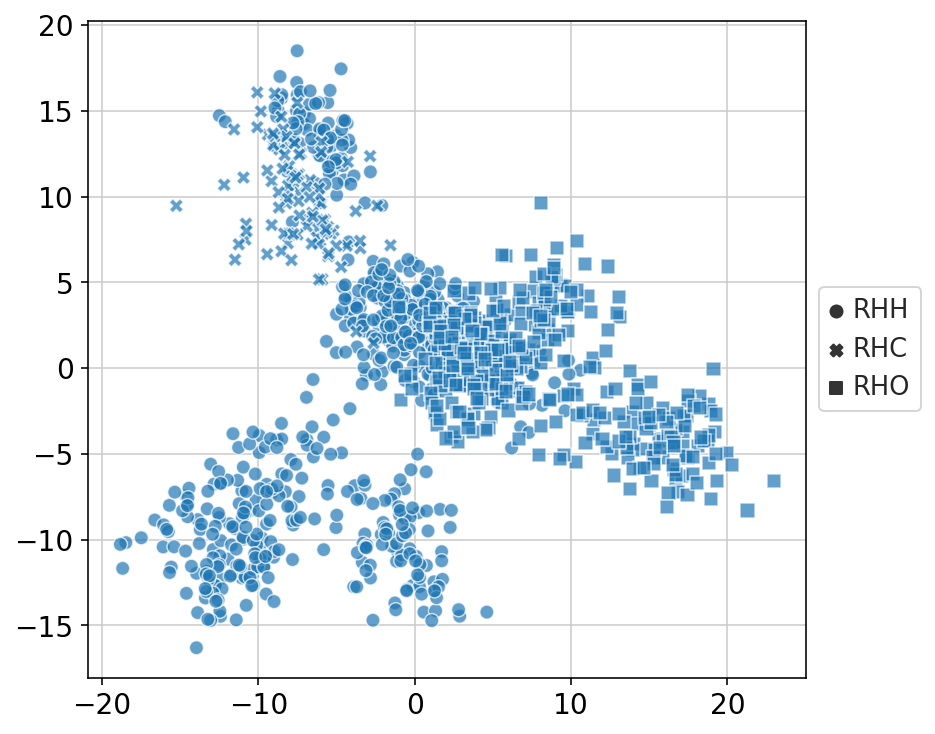

In [22]:
if ds_name == 'AS_et_al':

    fig, ax = plt.subplots(figsize=(8,6))

#     sns.scatterplot(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1], hue=adata.obs['cell_number_RHH'].values, style=adata.obs['batch'].values, palette='jet', s=50, alpha=0.7, ax=ax)
    sns.scatterplot(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1], style=adata.obs['batch'].values, palette='jet', s=50, alpha=0.7, ax=ax)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

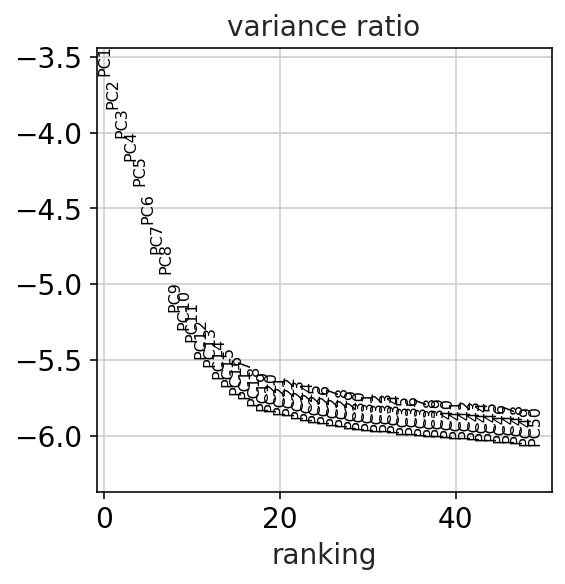

In [23]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

##### neighborhood graph

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, random_state=0, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


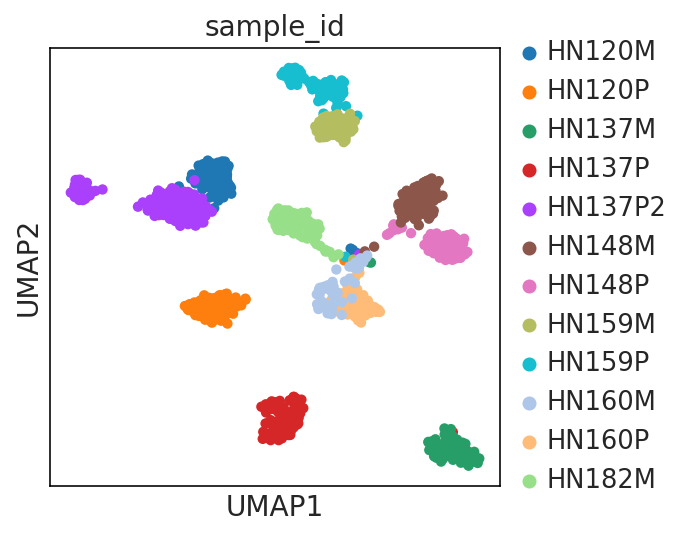

In [25]:
sc.tl.umap(adata, random_state=0)
# sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
sc.pl.umap(adata, color=['sample_id'])

##### Clustering

In [27]:
# adata.obs = adata.obs.drop([c for c in adata.obs.columns if 'louvain' in c], axis=1)

sc.tl.louvain(adata, random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


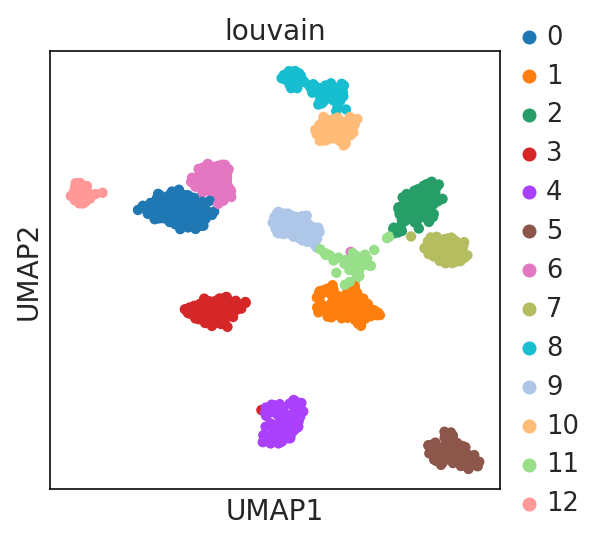

In [28]:
sc.pl.umap(adata, color=['louvain'])

In [29]:
# sc.tl.tsne(adata)
# sc.pl.tsne(adata, color=['louvain', 'cell_line_id', 'patient_id'])

In [30]:
sub_cluster_list = []
sub_adata_dict = {}

for i, n in adata.obs.groupby(['louvain'])['n_genes'].count().items():
    if n >= 50:
        sub_adata = adata[adata.obs['louvain'] == i, :]
        sub_adata_dict[i] = sub_adata
        sc.tl.louvain(sub_adata, key_added="louvain2", resolution=0.5)
        sub_cluster_list += [sub_adata.obs[['louvain2']]]

running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 3 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 3 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 1 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 2 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished: found 1 clusters and added
    'louvain2', the cluster labels (adata.obs, categorical) (0:00:00)


In [31]:
adata.obs = pd.merge(adata.obs, pd.concat(sub_cluster_list), how='left', left_index=True, right_index=True)

In [37]:
print (adata.obs.groupby(['louvain', 'louvain2'])[['n_counts']].count().dropna().shape)
adata.obs.groupby(['louvain', 'louvain2'])[['n_counts']].count().dropna()

(22, 1)


n_counts
louvain louvain2          
0       0             69.0
        1             69.0
1       0             57.0
        1             56.0
2       0             58.0
        1             38.0
3       0             58.0
        1             32.0
4       0             60.0
        1             15.0
        2             13.0
5       0             47.0
        1             21.0
        2             17.0
6       0             63.0
        1             22.0
7       0             85.0
8       0             53.0
        1             31.0
9       0             64.0
        1             18.0
10      0             81.0

In [33]:
import string

cluster_list = []

for c, dat in adata.obs.iterrows():
    l = string.ascii_uppercase[int(dat['louvain'])]
    if not pd.isnull(dat['louvain2']):
        l2 = int(dat['louvain2']) + 1
    else:
        l2 = ''
    
    cluster_list += ["{}{}".format(l, l2)]
    
adata.obs.loc[:, 'cluster'] = cluster_list

In [34]:
adata.obsm['X_pca']

array([[-4.14, -2.37, -9.04, ...,  0.99, -3.2 ,  0.99],
       [-7.92, -5.34, -4.9 , ..., -0.21, -1.32,  1.86],
       [-8.27, -7.21, -4.91, ...,  2.52, -0.03,  0.83],
       ...,
       [ 8.37,  4.53, -4.76, ..., -2.25,  1.44, -1.7 ],
       [ 5.69,  3.59, -3.72, ..., -1.17, -1.84,  1.41],
       [11.26,  3.26, -5.64, ...,  2.47,  0.39, -0.2 ]], dtype=float32)

In [38]:
cell_info_df = pd.merge(adata.obs, pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'], index=adata.obs.index), left_index=True, right_index=True)
cell_info_df = pd.merge(cell_info_df, pd.DataFrame(adata.obsm['X_pca'][:, 0:2], columns=['PC1', 'PC2'], index=adata.obs.index), left_index=True, right_index=True)
cell_info_df.head()

,sample_id,batch,cell_number,n_genes,percent_mito,n_counts,louvain,louvain2,cluster,UMAP1,UMAP2,PC1,PC2
RHH2176,HN120P,RHH,2176,3602,0.08,998435.88,11,NaN,L,6.52,6.08,-4.14,-2.37
RHH2177,HN120P,RHH,2177,5748,0.09,997598.06,3,0,D1,1.44,3.49,-7.92,-5.34
RHH2178,HN120P,RHH,2178,6648,0.12,995340.75,3,0,D1,1.23,3.30,-8.27,-7.21
RHH2179,HN120P,RHH,2179,7076,0.10,995187.62,3,0,D1,0.46,3.42,-12.39,-6.74
RHH2180,HN120P,RHH,2180,7261,0.11,993863.56,3,0,D1,0.18,2.98,-13.88,-8.84


In [49]:
cell_info_df.loc[:, 'patient_id'] = [s[0:5] for s in cell_info_df['sample_id']]
cell_info_df.loc[:, 'site'] = [s[5:] for s in cell_info_df['sample_id']]
cell_info_df.head()

,sample_id,batch,cell_number,n_genes,percent_mito,n_counts,louvain,louvain2,cluster,UMAP1,UMAP2,PC1,PC2,patient_id,site
RHH2176,HN120P,RHH,2176,3602,0.08,998435.88,11,NaN,L,6.52,6.08,-4.14,-2.37,HN120,P
RHH2177,HN120P,RHH,2177,5748,0.09,997598.06,3,0,D1,1.44,3.49,-7.92,-5.34,HN120,P
RHH2178,HN120P,RHH,2178,6648,0.12,995340.75,3,0,D1,1.23,3.30,-8.27,-7.21,HN120,P
RHH2179,HN120P,RHH,2179,7076,0.10,995187.62,3,0,D1,0.46,3.42,-12.39,-6.74,HN120,P
RHH2180,HN120P,RHH,2180,7261,0.11,993863.56,3,0,D1,0.18,2.98,-13.88,-8.84,HN120,P


In [40]:
cell_info_df['sample_id'] = cell_info_df['sample_id'].values.astype(str)

In [45]:
cell_info_df.groupby('sample_id').size()

sample_id
HN120M      90
HN120P      92
HN137M      86
HN137P      90
HN137P2    182
HN148M      93
HN148P      92
HN159M      79
HN159P      88
HN160M      55
HN160P      80
HN182M      89
dtype: int64

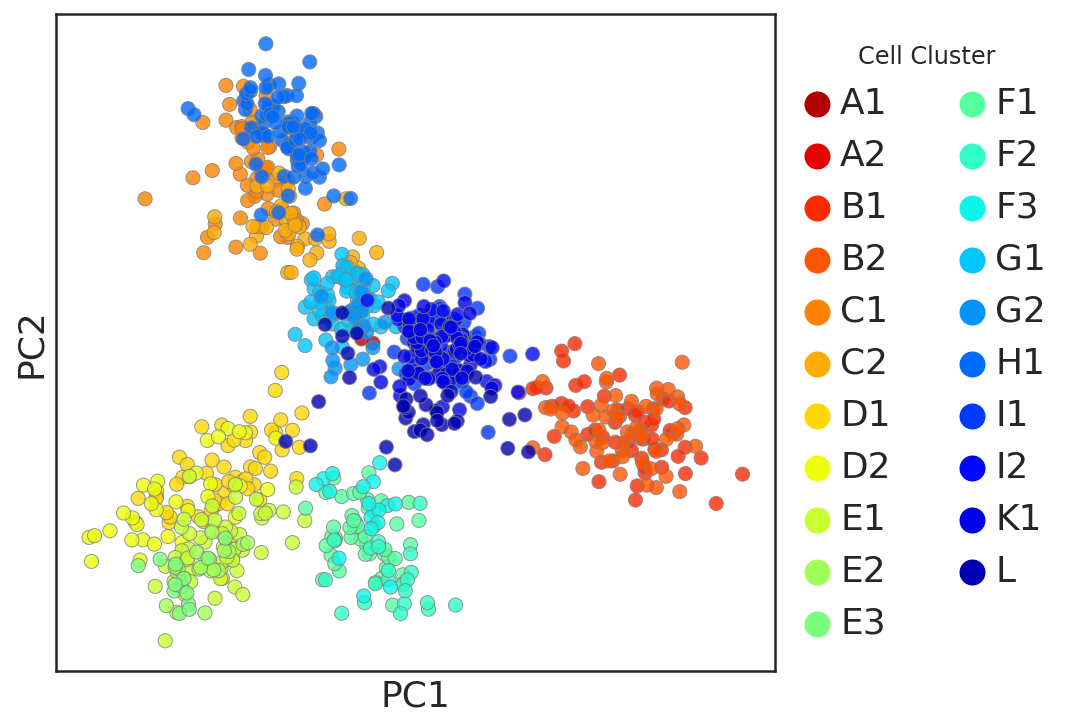

In [46]:
sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

# sns.scatterplot(data=cell_info_df[cell_info_df['sample_id']!='HN137P2'].sort_values('cluster'), x='PC1', y='PC2', hue='cluster', s=50, alpha=.8, linewidth=0.5, palette='jet_r', edgecolor='grey', ax=ax)
sns.scatterplot(data=cell_info_df[~cell_info_df['sample_id'].isin(['HN137P2', 'HN182M'])].sort_values('cluster'), x='PC1', y='PC2', hue='cluster', s=50, alpha=.8, linewidth=0.5, palette='jet_r', edgecolor='grey', ax=ax)


ax.set_xticks([], [])
ax.set_yticks([], [])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=2, fontsize='medium', framealpha=0, markerscale=2, title='Cell Cluster')

# plt.savefig('../figure/Fig3B_PCA_cluster.svg')

<Figure size 288x288 with 0 Axes>

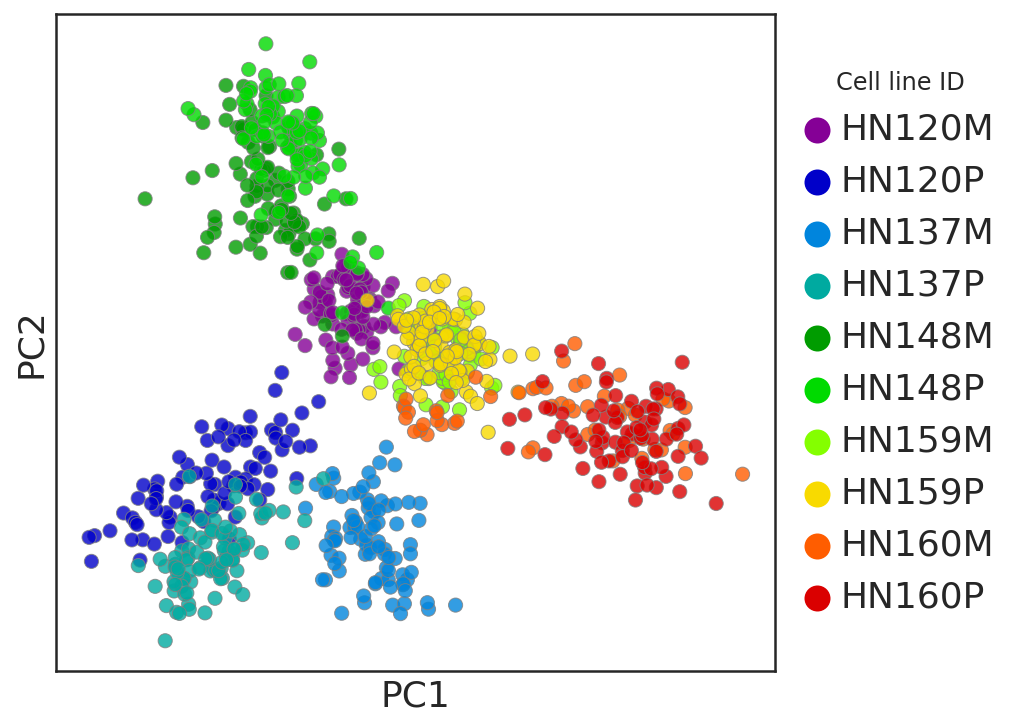

In [48]:
plt.clf()

sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8, 6))

# sns.scatterplot(data=cell_info_df[cell_info_df['sample_id']!='HN137P2'].sort_values('sample_id'), x='PC1', y='PC2', hue='sample_id', s=50, alpha=.8, linewidth=0.5, palette='nipy_spectral', edgecolor='grey', ax=ax)
sns.scatterplot(data=cell_info_df[~cell_info_df['sample_id'].isin(['HN137P2', 'HN182M'])].sort_values('sample_id'), x='PC1', y='PC2', hue='sample_id', s=50, alpha=.8, linewidth=0.5, palette='nipy_spectral', edgecolor='grey', ax=ax)

ax.set_xticks([], [])
ax.set_yticks([], [])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=1, fontsize='medium', framealpha=0, markerscale=2, title='Cell line ID')

# plt.savefig('../figure/Fig3B_PCA_cell_line.svg')

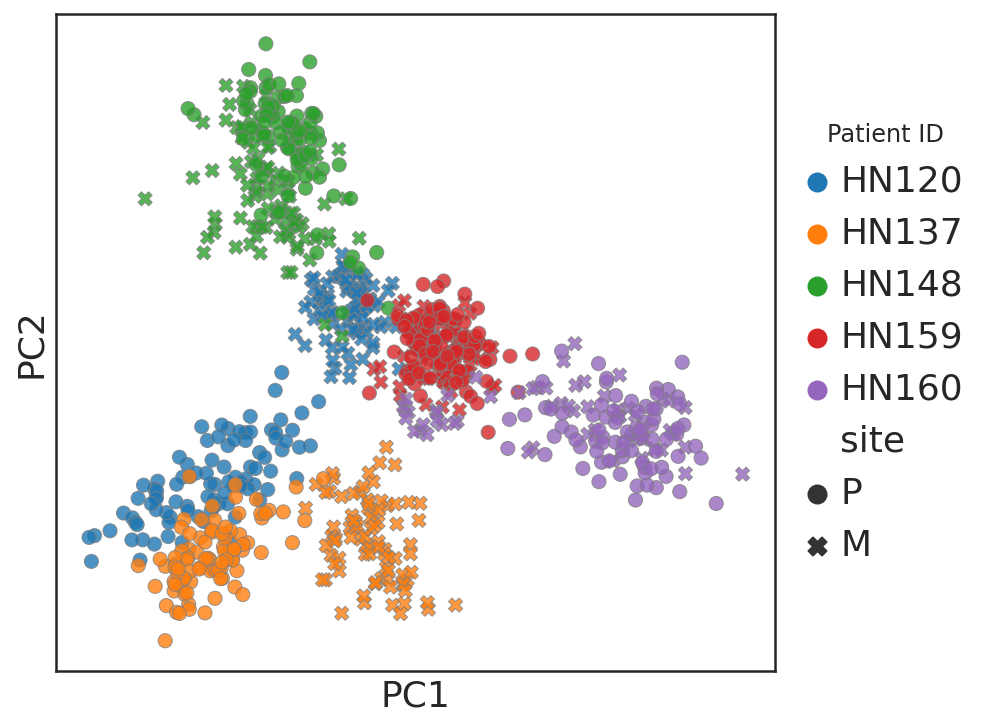

In [56]:
sns.set(font_scale=1.5, style='ticks')
fig, ax = plt.subplots(figsize=(8,6))

# sns.scatterplot(data=cell_info_df[cell_info_df['sample_id']!='HN137P2'].sort_values('patient_id'), x='PC1', y='PC2', hue='patient_id', style='patient_id', s=50, alpha=.8, linewidth=0.5, palette='tab10', edgecolor='grey', ax=ax)
sns.scatterplot(data=cell_info_df[~cell_info_df['sample_id'].isin(['HN137P2', 'HN182M'])].sort_values('patient_id'), x='PC1', y='PC2', hue='patient_id', style='site', s=50, alpha=.8, linewidth=0.5, palette='tab10', edgecolor='grey', ax=ax)

ax.set_xticks([], [])
ax.set_yticks([], [])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='center left', bbox_to_anchor=(1, 0.5), facecolor='white', ncol=1, fontsize='medium', framealpha=0, markerscale=1.5, title='Patient ID')

# plt.savefig('../figure/Fig3B_PCA_patient.svg')

In [ ]:
# cell_info_df.to_csv('../preprocessed_data/scRNAseq/{}_{}_cluster.csv'.format(ds_name, norm_type))

In [ ]:
# Counter(cell_info_df['sample_id'])